Curiosity is a car-sized unmanned rover designed to explore and examine the Gale crater on Mars. Launched on 26 November 2011 from Cape Canaveral, Curiosity touched down on Mars on 6 August 2012 for the start of its two year mission which was subsequently extended indefinitely.

One of the objectives of this mission was to learn more about the planet's climate and for this purpose, the rover is equipped with a series of instruments named Rover Environmental Monitoring Station(REMS), it contains all the weather instruments needed to provide daily and seasonal reports on meteorological conditions around the rover.

In [1]:
#importing necessary libraries
import opendatasets as od
import pandas as pd
import pymongo
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.image as pltimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
# import pydotplus
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
#reading csv files
client=pymongo.MongoClient("mongodb://127.0.0.1:27017/")
mydb=client['Mars_Application']
info=mydb.Database
cursor = info.find()
entries=list(cursor)
mars= pd.DataFrame(entries)
mars1= pd.DataFrame(entries)
mars.head()



,_id,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),wind_speed(m/h),humidity(%),sunrise,sunset,UV_Radiation,weather
0,6372ca965660fe95805fc48f,"Earth, 2022-01-26 UTC","Mars, Month 6 - LS 163°",Sol 3368,-3,-71,10,-84,707,Value not available,Value not available,05:25,17:20,moderate,Sunny
1,6372ca965660fe95805fc490,"Earth, 2022-01-25 UTC","Mars, Month 6 - LS 163°",Sol 3367,-3,-72,10,-87,707,Value not available,Value not available,05:25,17:20,moderate,Sunny
2,6372ca965660fe95805fc491,"Earth, 2022-01-24 UTC","Mars, Month 6 - LS 162°",Sol 3366,-4,-70,8,-81,708,Value not available,Value not available,05:25,17:21,moderate,Sunny
3,6372ca965660fe95805fc492,"Earth, 2022-01-23 UTC","Mars, Month 6 - LS 162°",Sol 3365,-6,-70,9,-91,707,Value not available,Value not available,05:26,17:21,moderate,Sunny
4,6372ca965660fe95805fc493,"Earth, 2022-01-22 UTC","Mars, Month 6 - LS 161°",Sol 3364,-7,-71,8,-92,708,Value not available,Value not available,05:26,17:21,moderate,Sunny


Cleaning the dataset for future use

In [2]:
mars=mars.rename(columns={'earth_date_time': 'earth_date',
                     'sol_number':'sol',
                     'max_ground_temp(°C)':'max_ground_temp',
                     'min_ground_temp(°C)':'min_ground_temp',
                     'max_air_temp(°C)':'max_air_temp',
                     'min_air_temp(°C)':'min_air_temp',
                     'mean_pressure(Pa)':'mean_pressure',
                     'wind_speed(m/h)':'wind_speed',
                     'humidity(%)':'humidity',
                     'UV_Radiation':'uv_radiation'} )

mars["sol"]=mars.sol.str.replace("Sol ,?","")
mars["earth_date"]=mars.earth_date.str.replace("Earth, | UTC,?","")
mars["mars_date_time"]=mars.mars_date_time.str.replace("°,?","")


mars["sol"] = mars["sol"].astype("int", errors='ignore')
# mars["sunrise"]= pd.to_datetime(mars["sunrise"])
# mars['sunrise'] = pd.Series([val.time() for val in mars['sunrise']])
# mars["sunset"]= pd.to_datetime(mars["sunset"])
# mars['sunset'] = pd.Series([val.time() for val in mars['sunset']])


# mars['sunrise'] = pd.to_datetime(mars['sunrise'], format='%H:%M')


# mars['sunrise'] = mars['sunrise'].apply(pd.Timestamp)
# mars['sunrise'].apply(pd.Timestamp)

# mars['sunset'] = pd.to_datetime(mars['sunset'], format='%H:%M')
# mars['sunset'] = mars['sunset'].apply(pd.Timestamp)
# mars['sunset'].apply(pd.Timestamp)

mars["max_ground_temp"] = mars["max_ground_temp"].astype("int", errors='ignore')
mars["min_ground_temp"] = mars["min_ground_temp"].astype("int", errors='ignore')
mars["max_air_temp"] = mars["min_air_temp"].astype("int", errors='ignore')
mars["mean_pressure"] = mars["mean_pressure"].astype("int", errors='ignore')
mars["wind_speed"] = mars["wind_speed"].astype("int", errors='ignore')



mars['avg_ground_temp'] = mars[['max_ground_temp', 'min_ground_temp']].mean(axis=1)
mars['avg_air_temp'] = mars[['max_air_temp', 'min_air_temp']].mean(axis=1)

# mars["solar_long"]=mars["mars_date_time"].str.replace("Mars, Month 6 - LS ,?","")
mars['solar_long'] = mars['mars_date_time'].str.replace(r'.*LS', '').astype(int)

mars['sunrise'] = pd.to_datetime(mars['sunrise'], format='%H:%M')
mars['sunset'] = pd.to_datetime(mars['sunset'], format='%H:%M')


# mars["solar_long"] = mars.astype({'solar_long':'int'})
# result = mars.dtypes
# print(result)

# mars["season"]=np.where(((mars.solar_long>=0) & (mars.solar_long<=89)),'Spring')

conditions = [
    (mars["solar_long"] >= 0) & (mars["solar_long"] < 90),
    (mars["solar_long"] >= 90) & (mars["solar_long"] < 180),
    (mars["solar_long"] >= 180) & (mars["solar_long"] < 270),
    (mars["solar_long"] >= 270) & (mars["solar_long"] <= 360)
]
values = ['Spring', 'Summer', 'Autumn', 'Winter']
mars['season'] = np.select(conditions, values)



conditions = [
    (mars["sol"] >= 0) & (mars["sol"] < 351),
    (mars["sol"] >= 351) & (mars["sol"] < 1019),
    (mars["sol"] >= 1019) & (mars["sol"] < 1688),
    (mars["sol"] >= 1688) & (mars["sol"] <= 2357),
    (mars["sol"] >= 2357) & (mars["sol"] <= 3024),
    (mars["sol"] >= 3024) & (mars["sol"] <= 3368)
]

values = ['Year 31', 'Year 32', 'Year 33', 'Year 34','Year 35','Year 36']

mars['mars_years'] = np.select(conditions, values)




options = ['Year 32', 'Year 33','Year 34','Year 35'] 
    
# selecting rows based on condition 
mars = mars[mars['mars_years'].isin(options)]



# mars["duration"] = datetime.combine(date.min, end) - datetime.combine(date.min, beginning)
mars['day_duration'] = mars['sunset'] - mars['sunrise']
mars['day_duration']=mars['day_duration']/np.timedelta64(1,'m')

mars.head()


/var/folders/_2/bwnpndcd41l350rv63l_1rk80000gn/T/ipykernel_7604/3476533549.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  mars["sol"]=mars.sol.str.replace("Sol ,?","")
/var/folders/_2/bwnpndcd41l350rv63l_1rk80000gn/T/ipykernel_7604/3476533549.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  mars["earth_date"]=mars.earth_date.str.replace("Earth, | UTC,?","")
/var/folders/_2/bwnpndcd41l350rv63l_1rk80000gn/T/ipykernel_7604/3476533549.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  mars["mars_date_time"]=mars.mars_date_time.str.replace("°,?","")
/var/folders/_2/bwnpndcd41l350rv63l_1rk80000gn/T/ipykernel_7604/3476533549.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the re

,_id,earth_date,mars_date_time,sol,max_ground_temp,min_ground_temp,max_air_temp,min_air_temp,mean_pressure,wind_speed,...,sunrise,sunset,uv_radiation,weather,avg_ground_temp,avg_air_temp,solar_long,season,mars_years,day_duration
318,6372ca965660fe95805fc5cd,2021-02-06,"Mars, Month 12 - LS 359",3023,-15,-74,-79,-79,818,Value not available,...,1900-01-01 06:41:00,1900-01-01 18:41:00,moderate,Sunny,NaN,NaN,359,Winter,Year 35,720.0
319,6372ca965660fe95805fc5ce,2021-02-05,"Mars, Month 12 - LS 358",3022,-2,-73,-78,-78,818,Value not available,...,1900-01-01 06:41:00,1900-01-01 18:41:00,moderate,Sunny,NaN,NaN,358,Winter,Year 35,720.0
320,6372ca965660fe95805fc5cf,2021-02-04,"Mars, Month 12 - LS 358",3021,-6,-74,-89,-89,819,Value not available,...,1900-01-01 06:42:00,1900-01-01 18:42:00,moderate,Sunny,NaN,NaN,358,Winter,Year 35,720.0
321,6372ca965660fe95805fc5d0,2021-02-03,"Mars, Month 12 - LS 357",3020,-7,-74,-76,-76,817,Value not available,...,1900-01-01 06:42:00,1900-01-01 18:42:00,moderate,Sunny,NaN,NaN,357,Winter,Year 35,720.0
322,6372ca965660fe95805fc5d1,2021-02-02,"Mars, Month 12 - LS 357",3019,-6,-73,-78,-78,816,Value not available,...,1900-01-01 06:42:00,1900-01-01 18:43:00,moderate,Sunny,NaN,NaN,357,Winter,Year 35,721.0


Total Daylight

In [3]:

  
# plotting the points 
fig=px.scatter(mars, x=mars["sol"], y=mars["day_duration"], color=mars["season"], 
title="Daylight variation during seasons in the years 32-35", labels={
                     "sol": "Sol Number(Days in mars)",
                     "day_duration": "Daylight(minutes)"
                 },width=800, height=400)


fig.update_layout(
    margin=dict(l=20, r=20, t=70, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

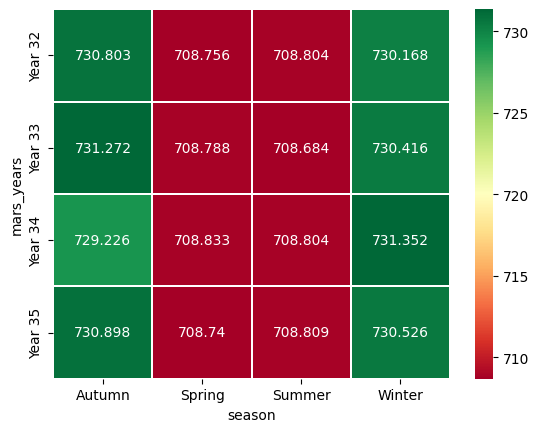

In [4]:

df_X=mars.pivot_table(index='mars_years', columns='season', values='day_duration', aggfunc='mean')
ax = sns.heatmap(df_X,annot=True,cmap='RdYlGn',linewidths=0.30,fmt='g')


2nd Analysis

Implementing Decision Tree Classification Algorithm from scratch

Decision Tree Classifier(Greedy Algorithm )

It is a binary tree that recursively splits the dataset till you're just left with pure leaf nodes.
Pure leaf nodes are basically the data with one type of class.
It consist of mainly two types of nodes namely Decision nodes and Leaf nodes.
In some cases if wwe don't have a 100% pure leaf node then we perform majority voting and classify the data based on majority in that leaf node.
Decisions in the decision node has to be made based on the what conditions produces a pure leaf node. 
We will have to compute entropy at each node and lower the entropy higher is the probability of a leaf node being pure.
entropy += -p_cls * np.log2(p_cls)
Maximum Information Gain has to be obtained in order to decide how to split the parent node into leaf nodes.(Model compares 1000's of conditions to check in which condition we have the maximum information gain).

###
###Node Class###
It will define the nodes of our decision Tree
Decision Node
Condition is defined by feature index and its threshold value
left and right are for accessing the left child and the right child
Information gain is info_gain.
Leaf Node
we just need the value-stores the majority class of the leaf node.

###
###Tree Node###

build_tree()->Function is the most important function of this algorithm.
First we Split the features and Targets into Variables X and Y 
using np.shape() we extract the features and samples
The first if statement checks if the stopping conditions of Node Class are met
Then get_best_split() function provides us the best split for a node.
Then we check if the information gain corresponding to this split is >0(if it is 0 then it is already pure)
Then we return the decision node with all of it's features
Then we compute the value of leaf node with calculate_leaf_value() function.
Then atlast we return the leaf node.



get_best_split()->Function returns a dictionary
We have used gini index for calculating the information gain 

#gini index is faster than entropy method since we have moidified the entropy formula by remove log hence we save valuable computation time. 


#fit()-> We have created a fir function to mimic the scikit fit function
 we are concatenating X and Y to create the dataset and then calling the build tree function.



In [5]:
## Node Class

class Node():
    def __init__(self,feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        '''constructor'''

        #for decision node
        self.feature_index=feature_index
        self.threshold=threshold
        self.left=left
        self.right=right
        self.info_gain=info_gain

        #for leaf node
        self.value=value


In [6]:
## Tree Class

class DecisionTreeClassifier():
    def __init__(self,min_samples_split=2, max_depth=2):
        '''constructor'''

        # initialize the root of the tree
        self.root= None

        # stopping conditions
        #if the number of samples becomes less than this then we won't split them further and treat it as a leaf node.
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):
        '''recursive function to build the tree'''

        X, Y = dataset[:,:-1],dataset[:,-1]
        num_samples,num_features = np.shape(X)

        #split until stopping conditions have been met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            #find the best split
            best_split=self.get_best_split(dataset,num_samples,num_features)
            #check if information gain is positive
            if best_split["info_gain"]>0:
                #recur left
                left_subtree=self.build_tree(best_split["dataset_left"],curr_depth+1)
                #recur right
                right_subtree=self.build_tree(best_split["dataset_right"],curr_depth+1)
                #return decision node
                return Node(best_split["feature_index"],best_split["threshold"],left_subtree,right_subtree,best_split["info_gain"])
        

        #compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        #return leaf node
        return Node(value=leaf_value)
    

    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")#negative infinity default value
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:#Check if the new information gain is more than the old one then we update it 
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])#Using list comprehension.
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [7]:
mars1.head()

,_id,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),wind_speed(m/h),humidity(%),sunrise,sunset,UV_Radiation,weather
0,6372ca965660fe95805fc48f,"Earth, 2022-01-26 UTC","Mars, Month 6 - LS 163°",Sol 3368,-3,-71,10,-84,707,Value not available,Value not available,05:25,17:20,moderate,Sunny
1,6372ca965660fe95805fc490,"Earth, 2022-01-25 UTC","Mars, Month 6 - LS 163°",Sol 3367,-3,-72,10,-87,707,Value not available,Value not available,05:25,17:20,moderate,Sunny
2,6372ca965660fe95805fc491,"Earth, 2022-01-24 UTC","Mars, Month 6 - LS 162°",Sol 3366,-4,-70,8,-81,708,Value not available,Value not available,05:25,17:21,moderate,Sunny
3,6372ca965660fe95805fc492,"Earth, 2022-01-23 UTC","Mars, Month 6 - LS 162°",Sol 3365,-6,-70,9,-91,707,Value not available,Value not available,05:26,17:21,moderate,Sunny
4,6372ca965660fe95805fc493,"Earth, 2022-01-22 UTC","Mars, Month 6 - LS 161°",Sol 3364,-7,-71,8,-92,708,Value not available,Value not available,05:26,17:21,moderate,Sunny


In [8]:
mars1.columns

Index(['_id', 'earth_date_time', 'mars_date_time', 'sol_number',
       'max_ground_temp(°C)', 'min_ground_temp(°C)', 'max_air_temp(°C)',
       'min_air_temp(°C)', 'mean_pressure(Pa)', 'wind_speed(m/h)',
       'humidity(%)', 'sunrise', 'sunset', 'UV_Radiation', 'weather'],
      dtype='object')

In [9]:
mars1.describe()

,_id,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),wind_speed(m/h),humidity(%),sunrise,sunset,UV_Radiation,weather
count,3197,3197,3197,3197,3197,3197,3197,3197,3197,3197,3197,3197,3197,3170,3197
unique,3197,3197,360,3197,52,40,51,78,224,1,1,90,96,4,2
top,6372ca965660fe95805fc48f,"Earth, 2022-01-26 UTC","Mars, Month 3 - LS 86°",Sol 3368,-6,-79,14,-78,873,Value not available,Value not available,05:18,17:20,moderate,Sunny
freq,1,1,12,1,130,221,154,165,47,3197,3197,170,199,1450,3194


In [10]:
mars1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   _id                  3197 non-null   object
 1   earth_date_time      3197 non-null   object
 2   mars_date_time       3197 non-null   object
 3   sol_number           3197 non-null   object
 4   max_ground_temp(°C)  3197 non-null   object
 5   min_ground_temp(°C)  3197 non-null   object
 6   max_air_temp(°C)     3197 non-null   object
 7   min_air_temp(°C)     3197 non-null   object
 8   mean_pressure(Pa)    3197 non-null   object
 9   wind_speed(m/h)      3197 non-null   object
 10  humidity(%)          3197 non-null   object
 11  sunrise              3197 non-null   object
 12  sunset               3197 non-null   object
 13  UV_Radiation         3170 non-null   object
 14  weather              3197 non-null   object
dtypes: object(15)
memory usage: 374.8+ KB


In [11]:
#Clean the dataset for  2nd Analysis
mars1=mars1.replace(r'Value not available', np.NaN, regex=True)
mars1['max_ground_temp(°C)'].unique()

array(['-3', '-4', '-6', '-7', '-8', '-9', '-5', '-14', '-16', '-20',
       '-12', '-15', '-13', '-11', '-21', '-23', '-10', '-17', '-18',
       '-19', '-30', '-27', '-28', '-29', '-26', '-33', '-31', '-32',
       '-67', '-37', '-34', '-24', '-22', '-25', '-2', '-1', '-54', nan,
       '1', '0', '2', '3', '4', '-53', '5', '6', '8', '7', '10', '11',
       '-35', '9'], dtype=object)

In [12]:
#Change the data type of 7 columns to float
# select the columns to convert to the float data type
columns = ["max_ground_temp(°C)", "min_ground_temp(°C)", "max_air_temp(°C)", "min_air_temp(°C)",           "mean_pressure(Pa)", "wind_speed(m/h)", "humidity(%)"]

# convert the selected columns to the float data type
mars1.loc[:, columns] = mars1.loc[:, columns].astype(float)
mars1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   _id                  3197 non-null   object 
 1   earth_date_time      3197 non-null   object 
 2   mars_date_time       3197 non-null   object 
 3   sol_number           3197 non-null   object 
 4   max_ground_temp(°C)  3169 non-null   float64
 5   min_ground_temp(°C)  3169 non-null   float64
 6   max_air_temp(°C)     3168 non-null   float64
 7   min_air_temp(°C)     3168 non-null   float64
 8   mean_pressure(Pa)    3170 non-null   float64
 9   wind_speed(m/h)      0 non-null      float64
 10  humidity(%)          0 non-null      float64
 11  sunrise              3197 non-null   object 
 12  sunset               3197 non-null   object 
 13  UV_Radiation         3170 non-null   object 
 14  weather              3194 non-null   object 
dtypes: float64(7), object(8)
memory usage:

/var/folders/_2/bwnpndcd41l350rv63l_1rk80000gn/T/ipykernel_7604/1152057882.py:6: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



In [13]:
# drop the 'wind_speed(m/h)' and 'humidity(%)' columns
mars1.drop(['wind_speed(m/h)', 'humidity(%)'], axis=1, inplace=True)

# drop rows with missing values
mars1.dropna(inplace=True)


In [14]:
#Replacing certain UV Radiation values for future Analysis
mars1['UV_Radiation'] = mars1['UV_Radiation'].replace(r'very_high', 'high', regex=True)
mars1['UV_Radiation'] = mars1['UV_Radiation'].replace(r'low', 'moderate', regex=True)
mars1['UV_Radiation'].value_counts()

high        1635
moderate    1533
Name: UV_Radiation, dtype: int64

In [15]:
#Creating a co-relation matrix- It displays the correlation coefficients for different variables.
#The following code creates the correlation matrix between all the features we are examining and our y-variable
#each cell basically is a corelation cooeficient
#A correlation coefficient is a number that denotes the strength of the relationship between two variables.
#Pearson’s coefficient denoted by the Greek letter ρ (rho).
#It is defined as the covariance between two variables divided by the product of the standard deviations of the two variables.
#The darker the shade of blue colour the stronger is the relationship between those two variables.
#A large positive value (near to 1.0) indicates a strong positive correlation, i.e., if the value of one of the variables increases, the value of the other variable increases as well.
#A large negative value (near to -1.0) indicates a strong negative correlation, i.e., the value of one variable decreases with the other’s increasing and vice-versa.
#A value near to 0 (both positive or negative) indicates the absence of any correlation between the two variables, and hence those variables are independent of each other.
mars_matrix = mars1.corr() 
mars_matrix.style.background_gradient(cmap='Blues')

/var/folders/_2/bwnpndcd41l350rv63l_1rk80000gn/T/ipykernel_7604/404860415.py:11: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa)
max_ground_temp(°C),1.000000,0.675160,0.822246,0.489733,-0.055522
min_ground_temp(°C),0.675160,1.000000,0.570791,0.646849,-0.005391
max_air_temp(°C),0.822246,0.570791,1.000000,0.268380,-0.088271
min_air_temp(°C),0.489733,0.646849,0.268380,1.000000,0.032279
mean_pressure(Pa),-0.055522,-0.005391,-0.088271,0.032279,1.000000


In [16]:
#Creating a specific Dataset and Y variable according to our analysis
values = ["max_ground_temp(°C)","min_ground_temp(°C)","max_air_temp(°C)","min_air_temp(°C)","mean_pressure(Pa)"]
main_val = mars1[values]
val = mars1[["UV_Radiation"]]

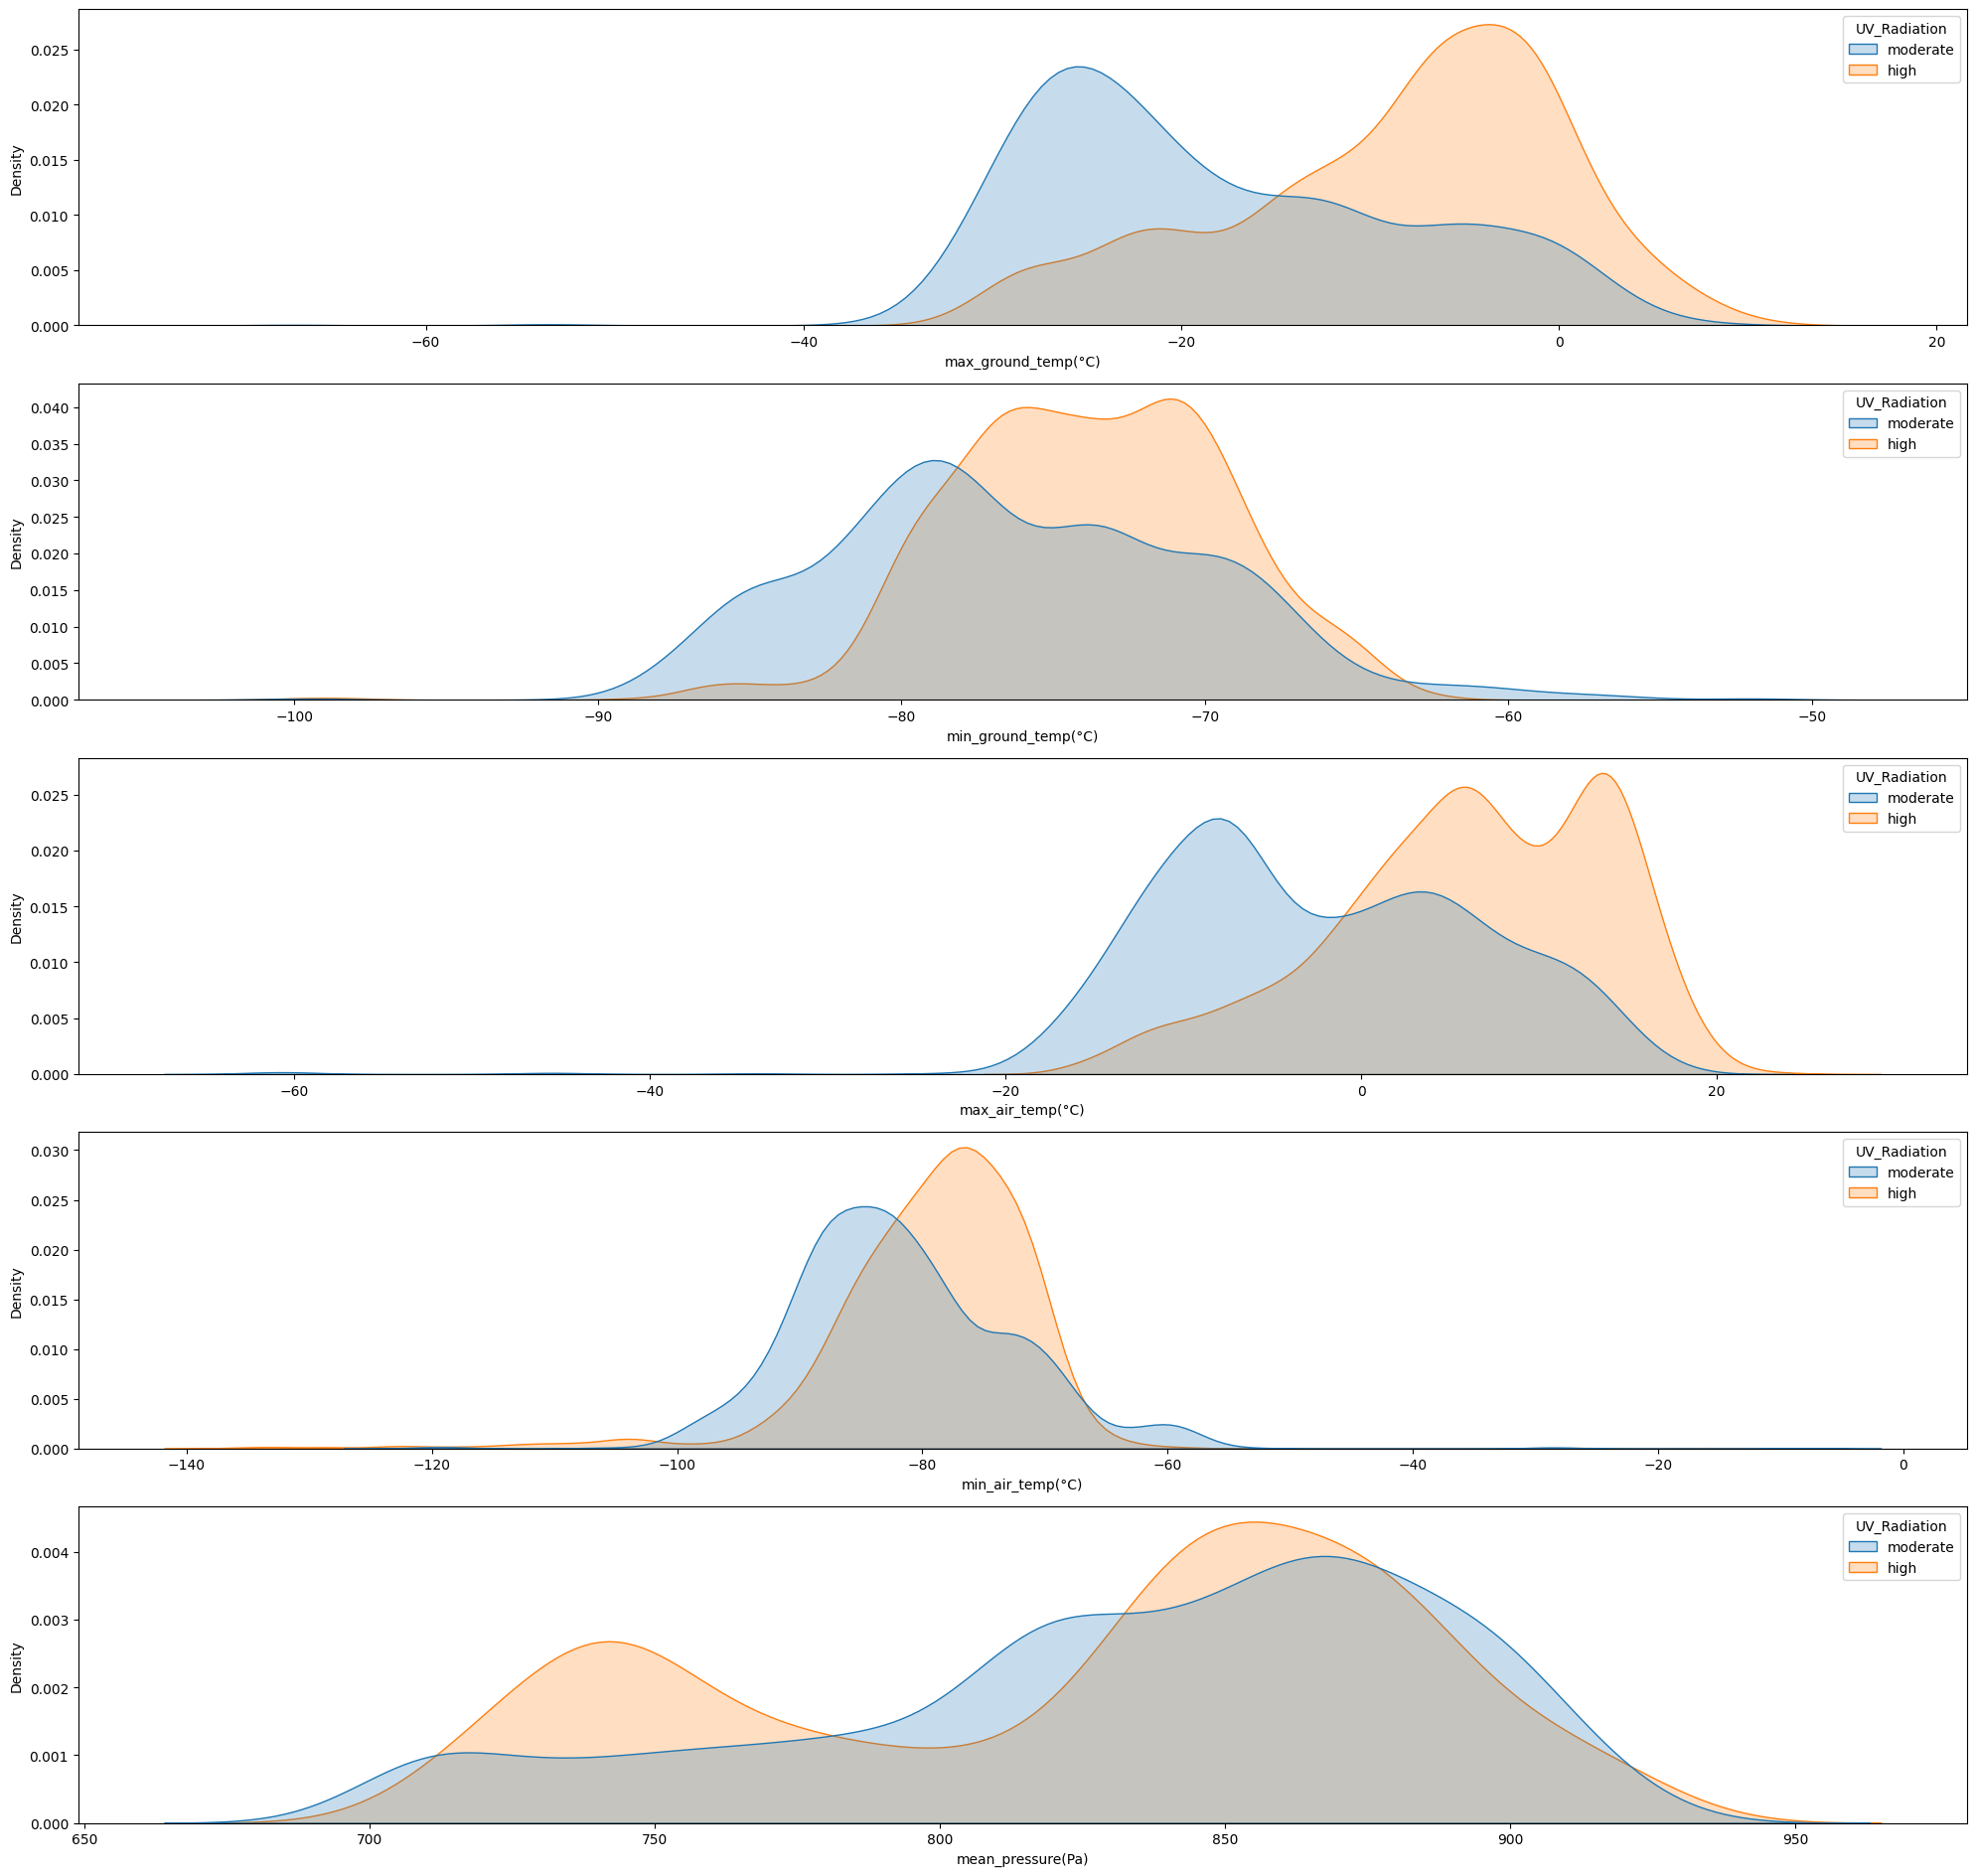

In [17]:
# create a figure with 16 subplots
plt.figure(figsize=(20, 60))

# iterate over the values in the 'values' list
for i, value in enumerate(values):
    # create a subplot
    plt.subplot(16, 1, i+1)

    # create a KDE plot using the 'mars1' data frame and the current value
    sns.kdeplot(data=mars1, x=value, hue="UV_Radiation", fill=True)

# adjust the layout of the subplots
plt.tight_layout()

In [18]:
#Essentially, the code is scaling the independent variables so that they lie in the range of 0 and 1. This is important because few 
# variable values might be in thousands and few might be in small ranges. Hence to handle such cases scaling is important.
#A way to normalize the input features/variables is the Min-Max scaler. By doing so, all features will be transformed into the range [0,1]
# meaning that the minimum and maximum value of a feature/variable is going to be 0 and 1, respectively.
# create a scaler object that scales values to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(main_val)

In [19]:
#Since, we have catagorical values we will be using OneHotEncoder, ML Algorithms cannot operate on this type of data so it needs to be converted
#So it is converted to numeric data via OneHotEncoder


core = OneHotEncoder(handle_unknown='ignore')
Var = core.fit_transform(val).toarray()

In [20]:
#NumPy arrays are faster and more compact than Python lists. An array consumes less memory and is convenient to use. NumPy uses much 
#less memory to store data and it provides a mechanism of specifying the data types.
Var = np.array(Var)
Var.shape

(3168, 2)

In [21]:

X_tr, X_Te, y_tr, y_Te = train_test_split(main_val, Var, test_size=0.2, random_state=42)


In [22]:
# import pydotplus


classification = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classification.fit(X_tr,y_tr)
classification.print_tree()

X_5 <= 0.0 ? 0.4990232288391685
 left:1.0
 right:0.0


In [23]:
from sklearn import tree
# import pydotplus
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier()
DTC = DTC.fit(X_tr, y_tr)


y_pred = DTC.predict(X_Te) 

In [24]:
Y_pred = []
Y_Test = []

# initialize the index variable to 0
i = 0

# loop until the index variable is equal to the length of y_pred
while i < len(y_pred):
    # append the predicted and actual values to the Y_pred and Y_Test lists
    Y_pred.append(np.argmax(y_pred[i]))
    Y_Test.append(np.argmax(y_Te[i]))
    
    # increment the index variable by 1
    i += 1
print(len(Y_pred))    
matrix_ = confusion_matrix(Y_Test, Y_pred) 

634


A confusion matrix is a table that describes the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

Confusion Matrix:
[[264  48]
 [ 64 258]]


Text(50.722222222222214, 0.5, 'Actual values ')

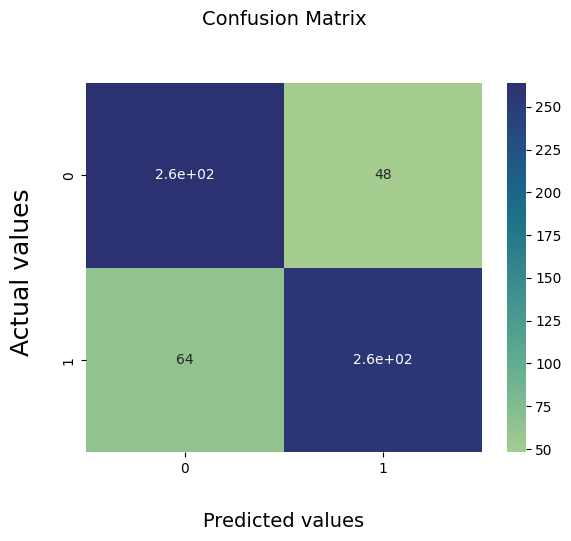

In [25]:
print("Confusion Matrix:")

print(matrix_)

variation = sns.heatmap(matrix_, annot=True, cmap='crest')

variation.set_title('Confusion Matrix\n\n',fontdict = {'size':14}, pad = 10)
variation.set_xlabel('\nPredicted values',fontdict = {'size':14}, labelpad = 10)
variation.set_ylabel('Actual values ',fontdict = {'size':18}, labelpad = 20)